 This Python 3 environment comes with many helpful analytics libraries installed
 It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
 For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

 Input data files are available in the read-only "../input/" directory
 For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"  You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# # for TPU
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

# # !pip install '../input/textstat-pypi/Pyphen-0.9.3-py2.py3-none-any.whl'
# # !pip install '../input/textstat-pypi/textstat-0.7.0-py3-none-any.whl'
# # from textstat.textstat import textstatistics,legacy_round


In [2]:
# #  XLA 

# import torch_xla
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.utils.utils as xu
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.test.test_utils as test_utils


# Load Libraries

In [3]:
import numpy as np 
import pandas as pd
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import KFold


from transformers import AutoModel, AutoTokenizer, BertTokenizer, AutoConfig

import itertools
import gc
import os 
import random

import spacy
import time
import timeit

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=1326)

# HyperParameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # for TPU
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

batch_size = 16
epochs = 15 # The number of epochs
embedding_dim = 300
MODEL_NAME =  '../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base'
# MODEL_NAME2 =  '../input/huggingface-roberta-variants/roberta-base/roberta-base'

# ../input/huggingface-bert/bert-base-cased
MODEL_NAME2 = None
useFeatures = False

# load dataframe

In [6]:
datadir = '/kaggle/input/commonlitreadabilityprize'
traindir = datadir + '/train.csv'
df = pd.read_csv('../input/commonlitfeatures/trainData_ReadabilityFeatures.csv').sample(frac = 1)

In [7]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print(method.__name__, (te - ts) * 1000)
        return result
    return timed

In [8]:
# Readability Features


# Splits the text into sentences, using
# Spacy's sentence segmentation which can
# be found at https://spacy.io/usage/spacy-101
def break_sentences(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    return list(doc.sents)
 
# Returns Number of Words in the text
def word_count(sentences):
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words
 
# Returns the number of sentences in the text
def sentence_count(sentences):
    return len(sentences)
 
# Returns average sentence length
def avg_sentence_length(sentences, words):
    average_length = float(words / sentences)
    return average_length
 
# Textstat is a python package, to calculate statistics from
# text to determine readability,
# complexity and grade level of a particular corpus.
# Package can be found at https://pypi.python.org/pypi/textstat
def syllables_count(word):
    word = str(word)
    syllable_count = 0
    vowels = 'aeiouy'
    if word[0] in vowels:
        syllable_count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            syllable_count += 1
    if word.endswith('e'):
        syllable_count -= 1
    if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
        syllable_count += 1
    if syllable_count == 0:
        syllable_count += 1
    return syllable_count
 
# Returns the average number of syllables per
# word in the text
def avg_syllables_per_word(sentences, words):
    syllable = 0
    for word in sentences:
        syllable += syllables_count(word)
    ASPW = float(syllable) / float(words)
    return round(ASPW, 1)
 
# Return total Difficult Words in a text
def difficult_words(sentences, text):
     
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    # Find all words in the text
    words = []
    for sentence in sentences:
        words += [str(token) for token in sentence]
 
    # difficult words are those with syllables >= 2
    # easy_word_set is provide by Textstat as
    # a list of common words
    diff_words_set = set()
     
    for word in words:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)
 
# A word is polysyllablic if it has more than 3 syllables
# this functions returns the number of all such words
# present in the text
def poly_syllable_count(text):
    count = 0
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [token for token in sentence]
     
 
    for word in words:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count
 
 
def flesch_reading_ease(avg_length , avg_syllables ):
    """
        Implements Flesch Formula:
        Reading Ease score = 206.835 - (1.015 × ASL) - (84.6 × ASW)
        Here,
          ASL = average sentence length (number of words
                divided by number of sentences)
          ASW = average word length in syllables (number of syllables
                divided by number of words)
    """
    FRE = 206.835 - float(1.015 * avg_length) -\
          float(84.6 * avg_syllables)
    return round(FRE, 2)
 
 
def gunning_fog(avgLength, diff, words):
    per_diff_words = (diff / words * 100) + 5
    grade = 0.4 * (avgLength + per_diff_words)
    return grade
 
 
def smog_index(text):
    """
        Implements SMOG Formula / Grading
        SMOG grading = 3 + ?polysyllable count.
        Here,
           polysyllable count = number of words of more
          than two syllables in a sample of 30 sentences.
    """
 
    if sentence_count(text) >= 3:
        poly_syllab = poly_syllable_count(text)
        SMOG = (1.043 * (30*(poly_syllab / sentence_count(text)))**0.5) \
                + 3.1291
        return round(SMOG, 1)
    else:
        return 0
 
 
def dale_chall_readability_score(words, avg_length, diff):
    """
        Implements Dale Challe Formula:
        Raw score = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365
        Here,
            PDW = Percentage of difficult words.
            ASL = Average sentence length
    """
    # Number of words not termed as difficult words
    count = words - diff
    if words > 0:
 
        # Percentage of words not on difficult word list
 
        per = float(count) / float(words) * 100
     
    # diff_words stores percentage of difficult words
    diff_words = 100 - per
 
    raw_score = (0.1579 * diff_words) + \
                (0.0496 * avg_length)
     
    # If Percentage of Difficult Words is greater than 5 %, then;
    # Adjusted Score = Raw Score + 3.6365,
    # otherwise Adjusted Score = Raw Score
 
    if diff_words > 5:      
 
        raw_score += 3.6365
         
    return round(raw_score, 2)



def flesch_reading_age(ASL, ASW):
    """
        Implements Flesch-Kincaid Grade Level Formula:
        Reading Ease score = (0.39 x ASL) + (11.8 x ASW) - 15.59
        Here,
          ASL = average sentence length (number of words
                divided by number of sentences)
          ASW = average word length in syllables (number of syllables
                divided by number of words)
                
    """
    
#     ASL = avg_sentence_length(text)
#     ASW = avg_syllables_per_word(text)
    
    FKRA = (0.39 * ASL) + (11.8 * ASW) - 15.59 
    return FKRA



# poly_syllable = []
# flesch_reading = []
# flesch_age = []
# gunning = []
# smog = []
# dale_chall = []
# wordCount = []
# avgSentenceLength = []
# avgSyllable = []


@timeit
def calculateFeatures(df):
    
    flesch_reading = []
    flesch_age = []
    gunning = []
    dale_chall = []
    wordCount = []
    avgSentenceLength = []
    avgSyllable = []
    
    for text in df['excerpt']:
        sentences = break_sentences(text)
        word_Count = word_count(sentences)
        avgLength = avg_sentence_length(len(sentences), word_Count)
        diffWords = difficult_words(sentences, text)
        avgSyllables = avg_syllables_per_word(sentences, word_Count)
        
        wordCount.append(word_Count)
        avgSentenceLength.append(avgLength)
        avgSyllable.append(avgSyllables)
        dale_chall.append(dale_chall_readability_score(word_Count,avgSyllables , diffWords ))
        flesch_age.append(flesch_reading_age(avgLength,  avgSyllables ))
        flesch_reading.append(flesch_reading_ease(avgLength , avgSyllables))
        gunning.append(gunning_fog(avgLength, diffWords, word_Count))

    df['flesch_age'] = flesch_age
    df['flesch_reading'] = flesch_reading
    df['wordCount'] = wordCount
    df['avgSentenceLength'] = avgSentenceLength
    df['avgSentenceSyllable'] = avgSyllable
    df['dale_chall'] = dale_chall
    df['gunning_fog'] = gunning


    
    
# calculateFeatures(df)
# df.head(5)


# df.to_csv('trainData_ReadabilityFeatures.csv', index=False)

# test_df = test_df['excerpt']
# calculateFeatures(test_df)

# CommonLitDataset

In [9]:
class CommonLitDataset(Dataset):
    def __init__(self, df):
        self.df = df 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.df.iloc[idx][1]
        text = self.df.iloc[idx][0]     
        if useFeatures:
            readability = np.array([x for x in self.df.iloc[idx][2:].values])
        else:
            readability = torch.zeros((1,7))
#         print(readability)
#         print(type(readability))
#         print(readability.shape)
        return text, label, readability
    

    
# train_data = CommonLitDataset(df)
# train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

# val_data = CommonLitDataset(df)
# val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

KFold_data = CommonLitDataset(df)


# Transformer Model

In [10]:
# Store the model we want to use
# MODEL_NAME = '/kaggle/input/huggingface-bert/bert-base-cased'


class CommonLitModel(nn.Module):
    def __init__(self,path, path2 = None):
        super(CommonLitModel,self).__init__()
        self.config = AutoConfig.from_pretrained(path)
        self.config.update({'output_hidden_states':True})
        self.bert = AutoModel.from_pretrained(path,output_hidden_states=False)
        
        if path2:
            self.bert2 = AutoModel.from_pretrained(path2, output_hidden_states = False) 
            self.linear1 = nn.Linear(1536,1536)
            self.linear2 = nn.Linear(1536,1)
        else:
            print('768 Features used')
            self.linear1 = nn.Linear(768,768)
            self.linear2 = nn.Linear(768,1)
            
            
        self.linear = nn.Linear(775,1)   
        self.dropout = nn.Dropout(0.50)
        self.lrelu = nn.LeakyReLU()
    

    def forward(self,xb, x2 = None, readability = None):
        x = self.bert(**xb)[1]
        if x2:
            x1 = self.bert2(**x2)[1]
            x = torch.cat((x, x1))
#             x = torch.mean(torch.stack([x, x1]))
        
#         x = self.dropout(x)
#         x = self.linear1(x)
#         x = self.lrelu(x) 
#         print(x.size())
#         print(readability.size())
        if useFeatures:
            x = torch.cat((x,readability),1)
            x = self.dropout(x)
            x = self.linear(x)
        else:
            x = self.dropout(x)
            x = self.linear2(x)
        return x
    
    

model = CommonLitModel(MODEL_NAME,MODEL_NAME2).to(device)
torch.save(model.state_dict(), 'initialModel')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if MODEL_NAME2:
    tokenizer2 = AutoTokenizer.from_pretrained(MODEL_NAME2)

768 Features used


In [11]:
import time

bptt = 35

criterion = nn.MSELoss()
lr = 0.00002 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay= 1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95, verbose = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


def train(model):
    model.train() # Turn on the train mode
    return_loss = []
    total_loss = 0.
    start_time = time.time()
#     src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    batch = 0
    for data, targets, readability in train_loader:
        model.train()
        optimizer.zero_grad()
      
        data1 = tokenizer.batch_encode_plus([*data],pad_to_max_length='max_length', return_tensors='pt').to(device)
        readability = torch.tensor(readability).float().to(device)
        if MODEL_NAME2:
            data2 = tokenizer2.batch_encode_plus([*data],pad_to_max_length='max_length', return_tensors='pt').to(device)
            final_output = model(data1 ,data2)
            
        else:
            final_output = model(data1 ,None, readability)
        targets = targets.float().to(device)
        final_output = torch.squeeze(final_output.float())
        loss = criterion(final_output, targets)


        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        return_loss.append(loss.item())
        log_interval = 100
        batch += 1
#         if batch % log_interval == 0 and batch > 0:
#             cur_loss = total_loss / log_interval
#             elapsed = time.time() - start_time
#             print('| epoch {:3d} | {:5d}/{:5d} batches | '
#                   'lr {:02.2f} | ms/batch {:5.2f} | '
#                   'loss {:5.2f} | ppl {:8.2f}'.format(
#                     epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
#                     elapsed * 1000 / log_interval,
#                     cur_loss, np.exp(cur_loss)))
        total_loss = 0
        start_time = time.time()
        
    return torch.mean(torch.tensor(return_loss))

def evaluate(eval_model):
#     losses = []
    eval_model.eval() # Turn on the evaluation mode
#     total_loss = 0.
    total_loss = []
    with torch.no_grad():
        for data, targets, readability in val_loader:
            
            data1 = tokenizer.batch_encode_plus([*data],pad_to_max_length='max_length', return_tensors='pt').to(device)
            readability = torch.tensor(readability).float().to(device)
            if MODEL_NAME2:
                data2 = tokenizer2.batch_encode_plus([*data],pad_to_max_length='max_length', return_tensors='pt').to(device)
                final_output = model(data1 ,data2)
            else:
                final_output = model(data1 , None, readability)
            targets = targets.float().to(device)
            final_output = torch.squeeze(final_output.float())
#             loss = criterion(final_output, targets)
            currLoss = criterion(final_output, targets).item()
#             total_loss += len(data) * currLoss
            total_loss.append(currLoss)

#     return total_loss
    return torch.mean(torch.tensor(total_loss))

# Regular Split

In [12]:
# best_val_loss = float("inf")
# best_model = None

# train_data = CommonLitDataset(df)
# train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

# val_data = CommonLitDataset(df)
# val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)


# train_losses = []
# val_losses = []
# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train_loss = train(best_val_loss)
#     val_loss = evaluate(model)
#     print('-' * 89)
#     print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '.format(epoch, (time.time() - epoch_start_time),val_loss))
#     print('-' * 89)
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model = model
#         torch.save(best_model, 'bestModel')

#     scheduler.step()
#     val_losses.append(val_loss)
#     train_losses.append(train_loss)
    
# #     print('Hi')
# #     print(train_losses)
# #     print('*' * 80)

#     if epoch % 5 == 0:
#         plt.plot(train_losses, label = "Train_Loss")
#         plt.plot(val_losses, label = "Val_Loss")
#         plt.show()
    

# Kfold validation

length of dataset is 2834
FOLD 0
--------------------------------
Starting epoch 1


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 37.67s | valid loss  0.36 | train loss  0.69 |
-----------------------------------------------------------------------------------------
Starting epoch 2
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 37.01s | valid loss  0.30 | train loss  0.32 |
-----------------------------------------------------------------------------------------
Starting epoch 3
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 36.95s | valid loss  0.28 | train loss  0.24 |
-----------------------------------------------------------------------------------------
Starting epoch 4
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 36.87s | valid loss  0.28 | train loss  0.20 |
-----------------------

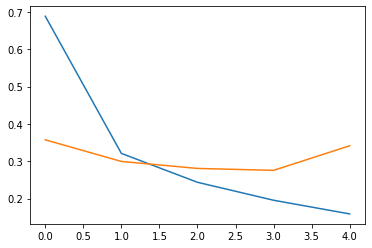

Starting epoch 6
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 36.94s | valid loss  0.46 | train loss  0.11 |
-----------------------------------------------------------------------------------------
Starting epoch 7
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 36.87s | valid loss  0.32 | train loss  0.09 |
-----------------------------------------------------------------------------------------
Starting epoch 8
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 36.86s | valid loss  0.38 | train loss  0.08 |
-----------------------------------------------------------------------------------------
Starting epoch 9
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 36.81s | valid loss  0.32 | train loss  0.07 |
------

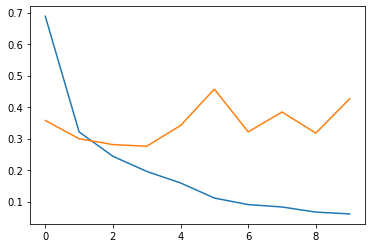

Starting epoch 11
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 36.84s | valid loss  0.43 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 12
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 36.84s | valid loss  0.39 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 13
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 36.72s | valid loss  0.43 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 14
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 36.71s | valid loss  0.45 | train loss  0.04 |
--

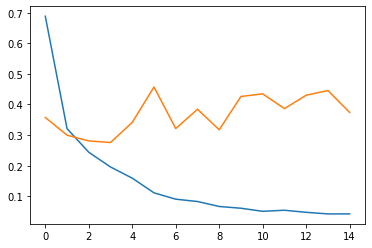

--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 36.80s | valid loss  0.33 | train loss  0.78 |
-----------------------------------------------------------------------------------------
Starting epoch 2
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 36.76s | valid loss  0.28 | train loss  0.35 |
-----------------------------------------------------------------------------------------
Starting epoch 3
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 36.89s | valid loss  0.32 | train loss  0.25 |
-----------------------------------------------------------------------------------------
Starting epoch 4
-----------------------------------------------------------------------------------------
| end o

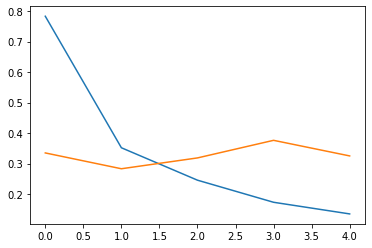

Starting epoch 6
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 36.88s | valid loss  0.37 | train loss  0.12 |
-----------------------------------------------------------------------------------------
Starting epoch 7
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 36.69s | valid loss  0.38 | train loss  0.09 |
-----------------------------------------------------------------------------------------
Starting epoch 8
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 36.66s | valid loss  0.41 | train loss  0.08 |
-----------------------------------------------------------------------------------------
Starting epoch 9
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 36.94s | valid loss  0.34 | train loss  0.06 |
------

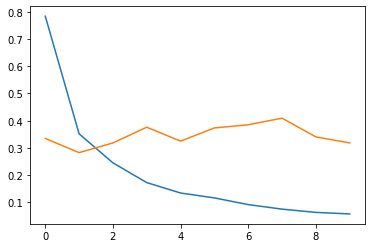

Starting epoch 11
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 36.73s | valid loss  0.43 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 12
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 36.63s | valid loss  0.34 | train loss  0.04 |
-----------------------------------------------------------------------------------------
Starting epoch 13
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 36.68s | valid loss  0.34 | train loss  0.04 |
-----------------------------------------------------------------------------------------
Starting epoch 14
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 36.75s | valid loss  0.32 | train loss  0.05 |
--

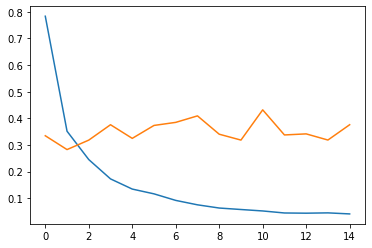

--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 36.96s | valid loss  0.47 | train loss  0.78 |
-----------------------------------------------------------------------------------------
Starting epoch 2
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 36.85s | valid loss  0.37 | train loss  0.36 |
-----------------------------------------------------------------------------------------
Starting epoch 3
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 37.02s | valid loss  0.34 | train loss  0.26 |
-----------------------------------------------------------------------------------------
Starting epoch 4
-----------------------------------------------------------------------------------------
| end o

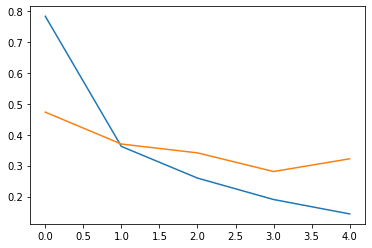

Starting epoch 6
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 37.03s | valid loss  0.36 | train loss  0.12 |
-----------------------------------------------------------------------------------------
Starting epoch 7
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 36.88s | valid loss  0.37 | train loss  0.09 |
-----------------------------------------------------------------------------------------
Starting epoch 8
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 36.99s | valid loss  0.30 | train loss  0.08 |
-----------------------------------------------------------------------------------------
Starting epoch 9
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 36.97s | valid loss  0.35 | train loss  0.07 |
------

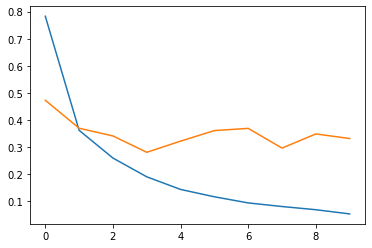

Starting epoch 11
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 37.02s | valid loss  0.38 | train loss  0.06 |
-----------------------------------------------------------------------------------------
Starting epoch 12
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 37.01s | valid loss  0.34 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 13
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 36.77s | valid loss  0.35 | train loss  0.04 |
-----------------------------------------------------------------------------------------
Starting epoch 14
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 36.85s | valid loss  0.33 | train loss  0.04 |
--

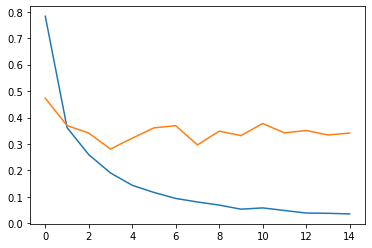

--------------------------------
FOLD 3
--------------------------------
Starting epoch 1
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 36.96s | valid loss  0.50 | train loss  0.79 |
-----------------------------------------------------------------------------------------
Starting epoch 2
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 36.77s | valid loss  0.33 | train loss  0.34 |
-----------------------------------------------------------------------------------------
Starting epoch 3
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 36.84s | valid loss  0.42 | train loss  0.26 |
-----------------------------------------------------------------------------------------
Starting epoch 4
-----------------------------------------------------------------------------------------
| end o

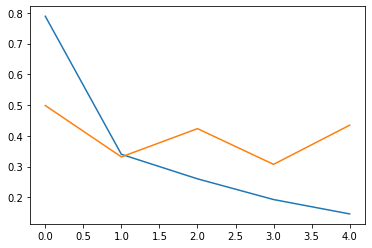

Starting epoch 6
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 36.75s | valid loss  0.42 | train loss  0.12 |
-----------------------------------------------------------------------------------------
Starting epoch 7
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 36.77s | valid loss  0.39 | train loss  0.09 |
-----------------------------------------------------------------------------------------
Starting epoch 8
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 36.96s | valid loss  0.29 | train loss  0.08 |
-----------------------------------------------------------------------------------------
Starting epoch 9
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 36.88s | valid loss  0.31 | train loss  0.07 |
------

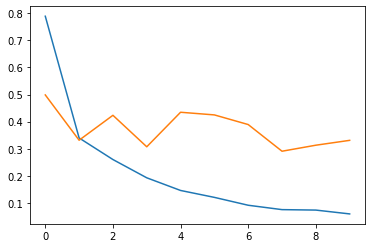

Starting epoch 11
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 36.85s | valid loss  0.35 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 12
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 36.78s | valid loss  0.31 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 13
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 36.83s | valid loss  0.31 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 14
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 36.88s | valid loss  0.30 | train loss  0.04 |
--

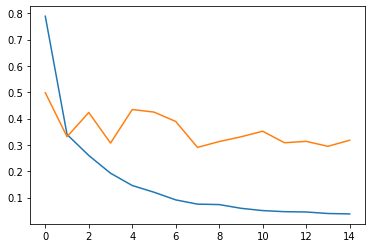

--------------------------------
FOLD 4
--------------------------------
Starting epoch 1
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 36.95s | valid loss  0.37 | train loss  0.88 |
-----------------------------------------------------------------------------------------
Starting epoch 2
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 36.78s | valid loss  0.30 | train loss  0.37 |
-----------------------------------------------------------------------------------------
Starting epoch 3
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 36.78s | valid loss  0.32 | train loss  0.27 |
-----------------------------------------------------------------------------------------
Starting epoch 4
-----------------------------------------------------------------------------------------
| end o

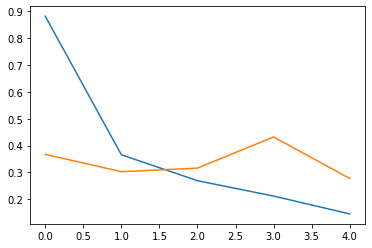

Starting epoch 6
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 36.78s | valid loss  0.31 | train loss  0.12 |
-----------------------------------------------------------------------------------------
Starting epoch 7
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 36.74s | valid loss  0.39 | train loss  0.09 |
-----------------------------------------------------------------------------------------
Starting epoch 8
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 36.94s | valid loss  0.36 | train loss  0.07 |
-----------------------------------------------------------------------------------------
Starting epoch 9
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 36.75s | valid loss  0.27 | train loss  0.07 |
------

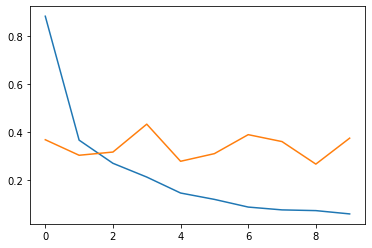

Starting epoch 11
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 36.92s | valid loss  0.38 | train loss  0.06 |
-----------------------------------------------------------------------------------------
Starting epoch 12
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 36.78s | valid loss  0.38 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 13
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 36.95s | valid loss  0.35 | train loss  0.05 |
-----------------------------------------------------------------------------------------
Starting epoch 14
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 36.86s | valid loss  0.31 | train loss  0.04 |
--

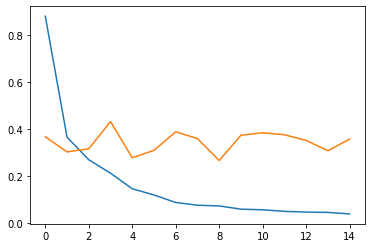

--------------------------------
*****************************************************************************************
KFold has ended!!!!!!
validation score is 0.35385990142822266
rmse is 0.5948612455255617
5
1
[tensor(0.3576), tensor(0.3347), tensor(0.4728), tensor(0.4986), tensor(0.3671)]
0.4061675
2
[tensor(0.2996), tensor(0.2828), tensor(0.3696), tensor(0.3315), tensor(0.3024)]
0.31717938
3
[tensor(0.2809), tensor(0.3184), tensor(0.3412), tensor(0.4234), tensor(0.3158)]
0.3359266
4
[tensor(0.2757), tensor(0.3761), tensor(0.2808), tensor(0.3072), tensor(0.4321)]
0.33438882
5
[tensor(0.3416), tensor(0.3249), tensor(0.3220), tensor(0.4346), tensor(0.2772)]
0.34007454
6
[tensor(0.4571), tensor(0.3734), tensor(0.3609), tensor(0.4248), tensor(0.3091)]
0.38509458
7
[tensor(0.3212), tensor(0.3849), tensor(0.3691), tensor(0.3893), tensor(0.3883)]
0.37056574
8
[tensor(0.3844), tensor(0.4093), tensor(0.2964), tensor(0.2909), tensor(0.3594)]
0.34806392
9
[tensor(0.3174), tensor(0.3405), t

In [13]:
# KFolds

kfold = KFold(n_splits= 5 , shuffle=True)


best_val_loss = float("inf")
best_model = None
epoch_averages = [[] for _ in range(epochs)]


fold_scores = []

print(f'length of dataset is {len(df)}')

for fold, (train_ids, val_ids) in enumerate(kfold.split(df)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # reset weights for the new fold
    model.load_state_dict(torch.load('initialModel'))

    
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = DataLoader(KFold_data, batch_size = batch_size, sampler = train_subsampler)
    val_loader = DataLoader(KFold_data, batch_size = batch_size, sampler = val_subsampler)
    
    
    train_losses = []
    val_losses = []
    
    # Run the training loop for defined number of epochs
    for epoch in range(1, epochs +1):
        # Print epoch
        print(f'Starting epoch {epoch}')
        epoch_start_time = time.time()


        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        train_loss = train(model)
        val_loss = evaluate(model)
        
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | train loss {:5.2f} |'.format(epoch, (time.time() - epoch_start_time),val_loss, train_loss))
        print('-' * 89)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = model
#             torch.save(best_model, 'bestModel')

#         scheduler.step()
        val_losses.append(val_loss)
        train_losses.append(train_loss)
        epoch_averages[epoch -1].append(val_loss)
        if epoch % 5 == 0:
            plt.plot(train_losses, label = "Train_Loss")
            plt.plot(val_losses, label = "Val_Loss")
            plt.show()
            
    fold_scores.append(np.mean(np.array(val_losses)))
    scheduler.step()

    
#   # Print fold results
#   print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
#   sum = 0.0
#   for key, value in results.items():
#     print(f'Fold {key}: {value} %')
#     sum += value
#   print(f'Average: {sum/len(results.items())} %')


print('*' * 89)
print('KFold has ended!!!!!!')
print(f'validation score is {np.mean(np.array(fold_scores))}')
print(f'rmse is {np.mean(np.array(fold_scores)) ** 0.5}')
print(len(fold_scores))



best_loss = float('inf')
best_epoch = 1
for epoch, values in enumerate(epoch_averages):
    print(epoch + 1)
    print(values)
    print(np.mean(values))
    if np.mean(values) < best_loss:
        best_loss = np.mean(values)
        best_epoch = epoch + 1
        
print(f'The best average loss is {best_loss} with epoch: {best_epoch}')

# Train model

In [14]:
train_data = CommonLitDataset(df)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)


model.load_state_dict(torch.load('initialModel'))

for epoch in range(1, best_epoch + 1):
# for epoch in range(1, 8 + 1):
        print('-' * 89)
        print(f'Starting epoch {epoch}')
        epoch_start_time = time.time()
        train_loss = train(model)
        print(f'| end of epoch: {epoch} | time: {time.time() - epoch_start_time}s  | train loss: {train_loss} |')
        print('-' * 89)

-----------------------------------------------------------------------------------------
Starting epoch 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


| end of epoch: 1 | time: 42.21211099624634s  | train loss: 0.7733760476112366 |
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Starting epoch 2
| end of epoch: 2 | time: 42.218443632125854s  | train loss: 0.3392130732536316 |
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Starting epoch 3
| end of epoch: 3 | time: 42.31486701965332s  | train loss: 0.24833659827709198 |
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Starting epoch 4
| end of epoch: 4 | time: 42.403817892074585s  | train loss: 0.17863254249095917 |
---------------------------------------------------------------------------------

# Save Model for inference

In [15]:
torch.save(model, 'bestModel')